In [288]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [289]:
#5a 

#calculate the electrostatic potential energy
k0 = 138.935456
def elecPotEnergy(ri, rj, qi, qj, sigmai, sigmaj, ei, ej):
    r_norm = np.linalg.norm(ri-rj)
    sigma = (sigmai + sigmaj)/2
    e = np.sqrt(ei*ej)
    
    CoulombPot = k0*qi*qj/r_norm
    ljPot = 4*e*((sigma/r_norm)**12-(sigma/r_norm)**6)
    PotEnergy = CoulombPot + ljPot

    #calculate the derivative of forces
    potDer = (-1*k0*qi*qj*(1/r_norm)**2) + (4*e * (-12*(sigma)**12*(1/r_norm)**13 + 6*(sigma)**6*(1/r_norm)** 7))
    force1 = -potDer * (ri-rj)/r_norm
    force2 = -force1

    return PotEnergy, force1, force2


#calculate the force field
def totalEnergy(crystalCoord, chargeArr, sigmaArr, eArr):
    E = 0
    forceMatrix = np.zeros((len(crystalCoord),3))
    #Force calculation
    for i in range (crystalCoord.shape[0]):
        for j in range (crystalCoord.shape[0]):
            if i < j:
                potential, forceI, forceJ= elecPotEnergy(crystalCoord[i], crystalCoord[j], chargeArr[i], chargeArr[j], sigmaArr[i], sigmaArr[j], eArr[i], eArr[j])
                forceMatrix[i] = forceMatrix[i] + forceI
                forceMatrix[j] = forceMatrix[j] + forceJ
                E += potential
    #Normalization of the force vector
    forceNorm = forceMatrix / np.linalg.norm(forceMatrix)
    
    return E, forceMatrix, forceNorm

def compute_kinetic_energy(v_curr, mass):
    KE = 0
    for i in range (0,len(v_curr)):
        KE += 0.5*mass[i] * np.sum(v_curr[i]**2)
    return KE

In [290]:
#setup the crystal structure
def build_crystal(n):
    spacing = 0.282 #unit in nm
    coord = []
    chargeArr = []
    sigmaArr = []
    eArr = []
    massArr = []
    for i in range (0, n):
        for j in range (0, n):
            for k in range (0, n):
                coord.append([i,j,k])
                if ((i+k)%2 == 0 and j%2 != 0) or ((i+k)%2 != 0 and j%2 == 0):
                    charge = 1
                    sigma = 0.332840
                    e = 0.011590
                    mass = 23
                else:
                    charge = -1
                    sigma = 0.440104
                    e = 0.418400
                    mass = 35
                chargeArr.append(charge)
                sigmaArr.append(sigma)
                eArr.append(e)
                massArr.append(mass)
    chargeArr = np.array(chargeArr)
    sigmaArr = np.array(sigmaArr)
    eArr = np.array(eArr)
    massArr = np.array(massArr)
    crystalCoord = np.array(coord) * spacing
    return crystalCoord, chargeArr, sigmaArr, eArr, massArr

In [291]:
#5b
crystalCoord, chargeArr, sigmaArr, eArr, massArr = build_crystal(4)
E, forceMatrix, forceNorm = totalEnergy(crystalCoord, chargeArr, sigmaArr, eArr)
print (E)

# xyz file
f = open('coordinate_check' + '.xyz','w')
print(len(crystalCoord),file=f)
print("Frame 0", file=f)
for n in range(0,len(crystalCoord)):
    if chargeArr[n] == 1:
        print("Na", "\t", crystalCoord[n][0]*10,"\t" ,crystalCoord[n][1]*10 ,"\t",crystalCoord[n][2]*10,file=f)
    if chargeArr[n] == -1:
        print("Cl", "\t", crystalCoord[n][0]*10,"\t" ,crystalCoord[n][1]*10 ,"\t",crystalCoord[n][2]*10,file=f)    
f.close()

-23961.69014300954


In [307]:
#5c

def init_optimize(coord, n_steps, stepsize):
     energyArr = []
     for i in range (n_steps):
         E, forceMatrix, forceNorm = totalEnergy(coord, chargeArr, sigmaArr, eArr)
         coord = coord + stepsize * forceNorm
         energyArr.append(E)
     energyArr = np.array(energyArr)
     return coord, energyArr[-1]

coordAfter, EAfter = init_optimize(crystalCoord, 1000, 0.001)
print ('The energy before initial 1000 steps optimization is ', E, 'KJ/mol')
print ('The energy after initial 1000 steps optimization is ', EAfter, 'KJ/mol')

The energy before initial 1000 steps optimization is  -23961.69014300954 KJ/mol
The energy after initial 1000 steps optimization is  -24023.96992645034 KJ/mol


In [ ]:
f = open('coordinate_afterinitopt' + '.xyz','w')
print(len(coordAfter),file=f)
print("Frame 0", file=f)
for n in range(0,len(coordAfter)):
    if chargeArr[n] == 1:
        print("Na", "\t", coordAfter[n][0]*10,"\t" ,coordAfter[n][1]*10 ,"\t",coordAfter[n][2]*10,file=f)
    if chargeArr[n] == -1:
        print("Cl", "\t", coordAfter[n][0]*10,"\t" ,coordAfter[n][1]*10 ,"\t",coordAfter[n][2]*10,file=f)    
f.close()

In [ ]:
def MB_velocity(v, T, mass):
    mass = (mass /1000)/Na
    beta = 1/(kb*T)
    term_1 = mass * beta / (2*np.pi)
    term_2 = - beta * mass * (v**2)/ 2
    Pv = (term_1)**(1/2) * np.exp (term_2) 
    return Pv

def MB_sample(mass, T):
    yAxis = MB_velocity(0,mass,T)
    while True:
        xValue = np.random.random()*1000-500
        yValue = np.random.random()*yAxis
    
        if yValue < MB_velocity(xValue, T, mass):

            break
    return xValue


In [338]:
#Maxwell_Boltzmann distribution calculation for initial velocity set up
kb = 1.3806452e-23  #unit in J/k
Na = 6.02214e23 #unit in 1/mol

def sample_normal(mass, T):
    mass = (mass/1000)/Na
    beta = 1/(kb*T)
    sigma = np.sqrt(1/(mass*beta))
    velocity = sigma * np.random.randn() /1000
    return velocity 

def initVelocity(coord, mass, T):
    velocities = np.zeros_like(coord)

    for i in range (0,len(velocities)):
        for j in range (0, 3):
            velocities[i][j] = sample_normal(mass[i], T)

    return velocities

#initial velocity
initVelocityArr = initVelocity(coordAfter, massArr, 1200)

In [388]:
#calculate the radius of gyration
def radiusOfGyration(coord):
    mean = np.mean(coord, axis = 0)
    distance = 0
    for i in range (len(coord)):
        distance +=  np.linalg.norm(coord[i] - mean)**2 
    Rg = np.sqrt(distance / len(coord))
    return Rg

In [389]:
#MD with velocity Verlet 
def dV (force, dt, mass):
    mass = np.repeat(mass,3)
    mass = np.reshape(mass,(64,3))
    dV = (force / mass)*dt 
    return dV

def dX(force, dt, v, mass):
    mass = np.repeat(mass,3)
    mass = np.reshape(mass,(64,3))
    dX = v*dt + 0.5*force*dt**2/mass 
    return dX

def MD(coord, time, dt, mass, T, charge, sigma, e):
    n_steps = time/dt
    x_traj = []
    pe_traj = []
    ke_traj = []
    radius_traj = []
    x_curr = coord
    v_curr = initVelocity(coord, mass, T)
    potential, forces, forceNorm = totalEnergy(x_curr, charge, sigma, e)
    x_traj.append(x_curr)
    resetVelocity = False

    for step in range (0,int(n_steps)): 
        pe_traj.append(potential)
        kinetic = compute_kinetic_energy(v_curr, mass)
        ke_traj.append(kinetic)
        x_dis = dX(forces, dt, v_curr, mass)
        x_curr += x_dis
        x_traj.append(x_curr)
        potential, forces, forceNorm = totalEnergy(x_curr, charge, sigma, e)
        v_dis = dV(forces, dt, mass)
        v_curr += v_dis
        if resetVelocity == True:
            if (step * dt) % 1 ==0:
                v_curr = initVelocity(x_curr, massArr, T)
                radius_traj.append(radiusOfGyration(x_curr))
    
    x_traj = np.array(x_traj)
    pe_traj = np.array(pe_traj)
    ke_traj = np.array(ke_traj)
    radius_traj = np.array(radius_traj)

    return x_traj, pe_traj, ke_traj, radius_traj

In [409]:
#MD with velocity Verlet 
def dV (force, dt, mass):
    mass = np.repeat(mass,3)
    mass = np.reshape(mass,(64,3))
    dV = (force / mass)*dt 
    return dV

def dX(force, dt, v, mass):
    mass = np.repeat(mass,3)
    mass = np.reshape(mass,(64,3))
    dX = v*dt + 0.5*force*dt**2/mass 
    return dX

def MD(coord, time, dt, mass, T, charge, sigma, e):
    n_steps = time/dt
    x_traj = []
    pe_traj = []
    ke_traj = []
    radius_traj = []
    x_curr = coord
    v_curr = initVelocity(coord, mass, T)
    potential, forces, forceNorm = totalEnergy(x_curr, charge, sigma, e)
    x_traj.append(x_curr)
    resetVelocity = True

    for step in range (int(n_steps)): 
        pe_traj.append(potential)
        kinetic = compute_kinetic_energy(v_curr, mass)
        ke_traj.append(kinetic)
        x_dis = dX(forces, dt, v_curr, mass)
        x_curr += x_dis
        x_traj.append(x_curr)
        potential, forces, forceNorm = totalEnergy(x_curr, charge, sigma, e)
        v_dis = dV(forces, dt, mass)
        v_curr += v_dis
        if resetVelocity == True:
            if (step * dt) % 1 ==0:
                v_curr = initVelocity(x_curr, massArr, T)
                radius_traj.append(radiusOfGyration(x_curr))
    
    x_traj = np.array(x_traj)
    pe_traj = np.array(pe_traj)
    ke_traj = np.array(ke_traj)
    radius_traj = np.array(radius_traj)


    return x_traj, pe_traj, ke_traj, radius_traj

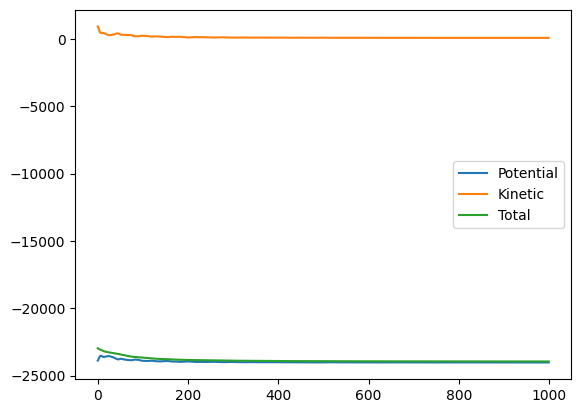

In [400]:
# 5c
x_traj, pe_traj, ke_traj, radius_traj= MD(coordAfter, 5, 0.005, massArr, 1200, chargeArr, sigmaArr, eArr)
fig, ax = plt.subplots()
ax.plot(pe_traj, label='Potential')
ax.plot(ke_traj, label='Kinetic')
ax.plot(pe_traj+ke_traj, label='Total')
ax.legend()

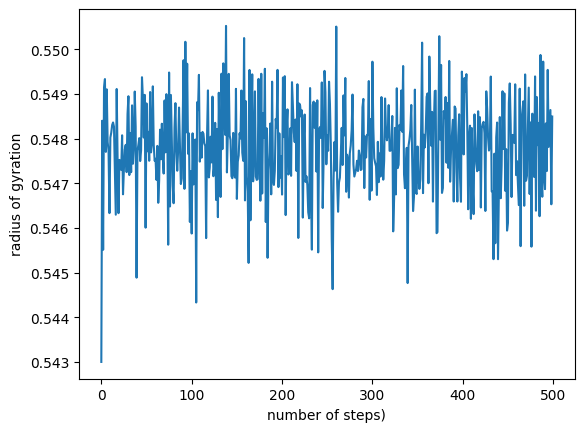

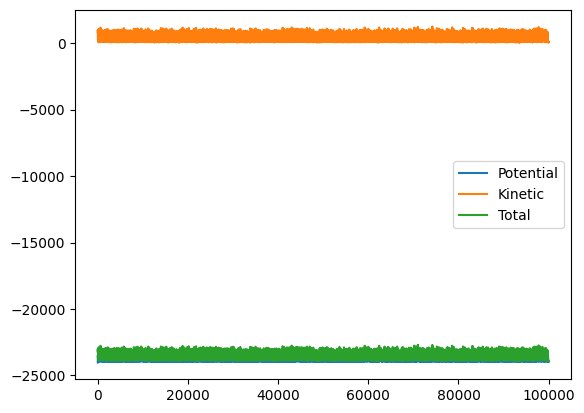

In [ ]:
#5d
x_traj_5d, pe_traj_5d, ke_traj_5d, radius_traj_5d = MD(coordAfter, 500, 0.005, massArr, 1200, chargeArr, sigmaArr, eArr)

plt.plot(radius_traj_5d)
plt.xlabel("number of steps)")
plt.ylabel("radius of gyration")
plt.show()

fig, ax = plt.subplots()
ax.plot(pe_traj_5d, label='Potential')
ax.plot(ke_traj_5d, label='Kinetic')
ax.plot(pe_traj_5d+ke_traj_5d, label='Total')
ax.legend()

In [413]:
#5e
print("The thermal equilibrium is roughly reach after 10 steps")

for i in range(radius_traj_5d.shape[0]):
    mean_5d = np.mean(radius_traj_5d[i])
    std_5d = np.std(radius_traj_5d[i])
print (mean_5d)
print (std_5d)

The thermal equilibrium is roughly reach after 10 steps
0.5484977736350909
0.0


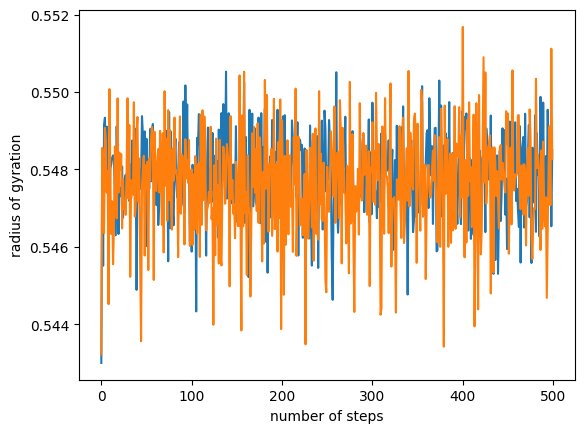

In [410]:
#5f
x_traj_5f, pe_traj_5f, ke_traj_5f, radius_traj_5f = MD(coordAfter, 500, 0.005, massArr, 1400, chargeArr, sigmaArr, eArr)

plt.plot(radius_traj_5d)
plt.plot(radius_traj_5f)
plt.xlabel("number of steps")
plt.ylabel("radius of gyration")
plt.show()


In [414]:
for i in range(radius_traj_5f.shape[0]):
    mean_5f = np.mean(radius_traj_5f[i])
    std_5f = np.std(radius_traj_5f[i])
print (mean_5f)
print (std_5f)

0.5482697950209465
0.0


In [415]:
alpha = (mean_5f - mean_5d)/200
alpha

-1.1398930707218202e-06

In [351]:
# xyz file for 5d
with open('trajectory_5d.xyz', 'w') as f:
    for frame in range(x_traj_5d.shape[0]):
        if frame%20 != 0: continue
        print("%i" % x_traj_5d.shape[1], file=f)
        print("Frame %i" % frame, file=f)
        for n in range(x_traj_5d.shape[1]):
            if chargeArr[n] == 1:
                print("Na", "\t", coordAfter[n][0]*10,"\t" ,coordAfter[n][1]*10 ,"\t",coordAfter[n][2]*10,file=f)
            if chargeArr[n] == -1:
                print("Cl", "\t", coordAfter[n][0]*10,"\t" ,coordAfter[n][1]*10 ,"\t",coordAfter[n][2]*10,file=f)    

In [418]:
#5g
x_traj_5g, pe_traj_5g, ke_traj_5g, radius_traj_5g = MD(coordAfter, 500, 0.005, massArr, 1300, chargeArr, sigmaArr, eArr)

In [419]:
for i in range(radius_traj_5g.shape[0]):
    mean_5g = np.mean(radius_traj_5f[i])
    std_5g = np.std(radius_traj_5f[i])
print (mean_5f)
print (std_5f)

0.5482697950209465
0.0
